# Google Colab initialization

This section will help you interface with Google Drive and clone the git repository where the code lives. These steps **aren't necessary if you are running locally**. First, make sure you have opened the notebook in Google Colab (use the below button if ncessary) and logged into your Google account.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/tanderson11/covid_households/blob/main/notebooks/ViolinsAndPowerCalc.ipynb)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
%mkdir /content/gdrive/My\ Drive/github/
%cd /content/gdrive/My\ Drive/github/
# Thayer has his files located here instead
#%cd /content/gdrive/My\ Drive/github/paper_push


In [ ]:
# If you've forked the repository, point to your own username and repository name (if different)
repo_owner="tanderson11"
repository="covid_households"

!git config --global user.email "tanderson11@gmail.com"
!git config --global user.name "Thayer Anderson"

In [ ]:
!git clone https://github.com/tanderson11/covid_households.git

In [ ]:
%cd covid_households/
!ls -a

# >>> TOKEN SETUP: <<<
# this will put your token in the right folder; comment this line out after use to avoid an error message
#!mv ../git_token.py ./
#!cp ../../covid_households/git_token.py ./

#from git_token import git_token

In [ ]:
!git checkout main
!git pull

In [ ]:
%cd ./notebooks

# Package initialization

In [3]:
%cd ../covid_households
import recipes
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype']=42

/Users/thayer/develop/covid_households/covid_households


In [4]:
import pandas as pd
pd.set_option('mode.chained_assignment', 'raise')

In [5]:
import model_inputs
#import rebuild
s80_axis = np.linspace(0.02, 0.80, 40)
p80_axis = np.linspace(0.02, 0.80, 40)
sar_axis = np.linspace(0.01, 0.60, 60)
axes_by_key = {'s80':s80_axis, 'p80':p80_axis, 'SAR':sar_axis}
big_region = recipes.SimulationRegion(axes_by_key, model_inputs.S80_P80_SAR_Inputs)

#try:
#    high_size_results = rebuild.rebuild(rebuild.gillespie_high_size_completed_dirs, rebuild.gillespie_high_size_dirs, '../new_parameters/gillespie-s80-p80-SAR/beta_corrections/high_sizes')
#except rebuild.MissingDataException as e:
#    exception = e

In [6]:
do_rebuild = False
import model_inputs
#import rebuild
if do_rebuild:
    s80_axis = np.linspace(0.02, 0.80, 40)
    p80_axis = np.linspace(0.02, 0.80, 40)
    sar_axis = np.linspace(0.01, 0.60, 60)
    axes_by_key = {'s80':s80_axis, 'p80':p80_axis, 'SAR':sar_axis}
    big_region = recipes.SimulationRegion(axes_by_key, model_inputs.S80_P80_SAR_Inputs)

    small_s80_axis = np.linspace(0.20, 0.80, 31)
    small_p80_axis = np.linspace(0.20, 0.80, 31)
    small_sar_axis = np.linspace(0.10, 0.60, 51)
    small_axes_by_key = {'s80':small_s80_axis, 'p80':small_p80_axis, 'SAR':small_sar_axis}
    small_region = recipes.SimulationRegion(small_axes_by_key, model_inputs.S80_P80_SAR_Inputs)

    results = rebuild.rebuild(rebuild.gillespie_completed_dirs, rebuild.gillespie_from_parts_dirs, '../new_parameters/gillespie-s80-p80-SAR/beta_corrections', overwrite_dirs=rebuild.gillespie_overwrite_dirs, check_region=big_region)
    #results = rebuild.rebuild(rebuild.tweaked_dprob_completed_dirs, rebuild.tweaked_dprob_from_parts_dirs, '../new_parameters/s80-p80-SAR-sizes-2-8-tweaked-dprobability', check_region=small_region)
else:
    #results = recipes.Results.load('../new_parameters/s80-p80-SAR-sizes-2-8-tweaked-dprobability')
    #results = recipes.Results.load('../new_parameters/gillespie-s80-p80-SAR')
    results = recipes.Results.load('../new_parameters/gillespie-s80-p80-SAR/beta_corrections')

In [7]:
results.df.loc[0.02, 0.04, 0.11]

count  sus_variance  inf_variance   beta  \
size infections                                                
2    1           190203.0        1000.0       827.865  0.743   
     2             9797.0        1000.0       827.865  0.743   
3    1           179966.0        1000.0       827.865  0.743   
     2            14351.0        1000.0       827.865  0.743   
     3             5683.0        1000.0       827.865  0.743   
4    1           170502.0        1000.0       827.865  0.743   
     2            16568.0        1000.0       827.865  0.743   
     3             8499.0        1000.0       827.865  0.743   
     4             4431.0        1000.0       827.865  0.743   
5    1           162370.0        1000.0       827.865  0.743   
     2            17334.0        1000.0       827.865  0.743   
     3             9695.0        1000.0       827.865  0.743   
     4             6720.0        1000.0       827.865  0.743   
     5             3881.0        1000.0       827.865  0.743   
6    1           154884.0        1000.0       827.865  0.743   
     2            17707.0        1000.0       827.865  0.743   
     3            10084.0        1000.0       827.865  0.743   
     4             7757.0        1000.0       827.865  0.743   
     5             5928.0        1000.0       827.865  0.743   
     6             3640.0        1000.0       827.865  0.743   
7    1           147967.0        1000.0       827.865  0.743   
     2            17723.0        1000.0       827.865  0.743   
     3            10161.0        1000.0       827.865  0.743   
     4             8051.0        1000.0       827.865  0.743   
     5             6926.0        1000.0       827.865  0.743   
     6             5649.0        1000.0       827.865  0.743   
     7             3523.0        1000.0       827.865  0.743   
8    1           142192.0        1000.0       827.865  0.743   
     2            17048.0        1000.0       827.865  0.743   
     3             9966.0        1000.0       827.865  0.743   
     4             7915.0        1000.0       827.865  0.743   
     5             7436.0        1000.0       827.865  0.743   
     6             6647.0        1000.0       827.865  0.743   
     7             5495.0        1000.0       827.865  0.743   
     8             3301.0        1000.0       827.865  0.743   

                 inf_constant_value  sus_constant_value  frequency  
size infections                                                     
2    1                          NaN                 NaN   0.951015  
     2                          NaN                 NaN   0.048985  
3    1                          NaN                 NaN   0.899830  
     2                          NaN                 NaN   0.071755  
     3                          NaN                 NaN   0.028415  
4    1                          NaN                 NaN   0.852510  
     2                          NaN                 NaN   0.082840  
     3                          NaN                 NaN   0.042495  
     4                          NaN                 NaN   0.022155  
5    1                          NaN                 NaN   0.811850  
     2                          NaN                 NaN   0.086670  
     3                          NaN                 NaN   0.048475  
     4                          NaN                 NaN   0.033600  
     5                          NaN                 NaN   0.019405  
6    1                          NaN                 NaN   0.774420  
     2                          NaN                 NaN   0.088535  
     3                          NaN                 NaN   0.050420  
     4                          NaN                 NaN   0.038785  
     5                          NaN                 NaN   0.029640  
     6                          NaN                 NaN   0.018200  
7    1                          NaN                 NaN   0.739835  
     2                          NaN                 NaN   0.0886

In [7]:
results.df.loc[0.08, 0.5, 0.01, 4]

,count,sus_variance,inf_variance,beta,inf_constant_value,sus_constant_value,frequency
infections,,,,,,,
1,198009.0,154.624,1.031,0.002,NaN,NaN,0.990045
2,1906.0,154.624,1.031,0.002,NaN,NaN,0.009530
3,85.0,154.624,1.031,0.002,NaN,NaN,0.000425
4,0.0,154.624,1.031,0.002,NaN,NaN,0.000000


In [8]:
results.find_frequencies(inplace=True)

s80   p80   SAR   size  infections
0.02  0.02  0.01  2     1             0.997565
                        2             0.002435
                  3     1             0.993942
                        2             0.005480
                        3             0.000577
                                        ...   
0.80  0.80  0.60  8     4             0.000000
                        5             0.000000
                        6             0.000000
                        7             0.000000
                        8             0.992920
Name: count, Length: 3360000, dtype: float64

# Violin figures

The cells in this section are used to generate violin plots (as in Figure 3 in the paper). The first block of cells configures the simluated data set, the second block of cells produces the simulated data, and the third block of cells plots the actual figures.

To change the parameters of the violin plots, change the values of `population_mixes` (what population structure to use for the simulated data), `sample_sizes` (the # of individuals to simulate in the population divided according to the population mix) and `parameter_sets` (the tuples of ($s_{80}$, $p_{80}$, $\text{SAR}$) to simulate).

## Prepartion for running violin fits

`null_freqs` represents the frequencies we observe in the absence of heterogeneity. We use it to calculate the MLE along the restriction where heterogeneity is not present.

In [9]:
freq = results.df['frequency']
s80_l = freq.index.get_level_values(0)
p80_l = freq.index.get_level_values(1)

null_freqs = freq[(s80_l == 0.8) & (p80_l == 0.8)]
null_freqs

s80  p80  SAR   size  infections
0.8  0.8  0.01  2     1             0.989690
                      2             0.010310
                3     1             0.979630
                      2             0.019695
                      3             0.000675
                                      ...   
          0.60  8     4             0.000000
                      5             0.000000
                      6             0.000000
                      7             0.000000
                      8             0.992920
Name: frequency, Length: 2100, dtype: float64

In [10]:
def make_mles(logl, population, parameter_set, population_name=None):
    """Takes the log likelihood surface for each configuration and returns the MLEs (one for each trial).

    Args:
        logl (Pandas.DataFrame): the loglikelihood surface. Indexed by at least `trial` which represent different observations
        population (dict): a dictionary of household size --> number of households.
        parameter_set (tuple): the value of each parameter that in fact produced the simulated data

    Returns:
        Pandas.DataFrame: a dataframe of MLE values with one column for each parameter inferred
    """
    fits = logl.groupby('trial').idxmax()
    fits = pd.DataFrame(fits.tolist())
    new_names = []
    for name in logl.index.names:
        name = name if name == 'trial' else 'MLE_' + name
        new_names.append(name)
    fits.columns = new_names
    fits.set_index('trial')

    fits['sample size'] = sum([k*v for k,v in population.items()])
    if population_name is not None:
        fits['population mix'] = population_name
    else:
        fits['population mix'] = [tuple(population.keys()) for i in range(len(fits))]
    fits ['parameters'] = [parameter_set] * len(fits)
    return fits

Choose the different combinations of parameters / sample sizes / household sizes to try.

In [11]:
#   Two  | Three	 Four     Five    Six    Seven or more
# 2021
# 45,515 | 19,523 | 16,098 | 7,577 | 2,635 |     1,611
# https://www.census.gov/data/tables/time-series/demo/families/households.html
# Let's take households of size > 2 and assume that 'seven or more' --> equal mix of 7 and 8
American_households_size_ge_3 = {3:19523, 4:16098, 5:7577, 6:2635, 7:1611//2, 8:1611//2}
America_households_total = np.sum([v for v in American_households_size_ge_3.values()])
named_populations = {'America_census':{k:v/America_households_total for k,v in American_households_size_ge_3.items()}}
population_descriptions = {'America_census': 'divided in proportion to American households of size >=3'}
# Here we do the same thing for America but we take households of size >= 2
American_households_size_ge_2 = {2:45515, 3:19523, 4:16098, 5:7577, 6:2635, 7:1611//2, 8:1611//2}
America_households_total_incl_2 = np.sum([v for v in American_households_size_ge_2.values()])
named_populations['America_census_incl_2'] = {k:v/America_households_total_incl_2 for k,v in American_households_size_ge_2.items()}
population_descriptions['America_census_incl_2'] = 'divided in proportion to American households of size >=2'

# UN data: https://www.un.org/development/desa/pd/data/household-size-and-composition

# A few other countries
# Percent 1 | 2-3 | 4-5 | 6+
# Philippines [2017] (average size = 4.23)
# 9.18	30.05	36.82	23.95
philippines_percents = [9.18, 30.05, 36.82, 23.95]
# Guatemala [2015] (average size = 4.8)
# 4.33	26.57	37.51	31.60
guatemala_percents = [4.33, 26.57, 37.51, 31.60]
guatemala_average = 4.8
# US [2015] (average size = 2.49)
# 27.89	49.49	18.81	3.81
us_percents = [27.89, 49.49, 18.81, 3.81]
# Mexico [2015] (Average size 3.74)
# 10.08	37.68	37.75	14.49
mexico_percents = [10.08, 37.68, 37.75, 14.49]

# Let's be dumb about it and just assume that you are evenly mixed within the bucket and that 6+ stops at 6
# Don't anchor to the average, just calculate the residual

buckets = [(1,1), (2,3), (4,5), (6,6)]
def uniform_buckets(percents, left_cutoff=None):
    np_population = np.zeros(10)
    for i,bucket in enumerate(buckets):
        left, right = bucket
        average_percent = percents[i] / (right - left + 1)
        for size in range(left, right+1):
            np_population[size] = average_percent
    if left_cutoff is not None:
        np_population[:left_cutoff] = 0
        remaining_percent = np.sum(np_population)
        np_population = np_population * 100 / (remaining_percent)
    population = {}
    for size, percent in enumerate(np_population):
        if percent == 0:
            continue
        population[size] = percent/100
    return population

named_populations.update({
    'America_UN':uniform_buckets(us_percents, left_cutoff=3),
    'Mexico_incl_2':uniform_buckets(mexico_percents, left_cutoff=2),
    'Philippines_incl_2':uniform_buckets(philippines_percents, left_cutoff=2),
    'Guatemala_incl_2':uniform_buckets(guatemala_percents, left_cutoff=2),
})

population_descriptions.update({
    'America_UN':'US households size >= 3 estimated from UN',
    'Mexico_incl_2':'Mexican households size >= 2 estimated from UN',
    'Philippines_incl_2':'Philippine households size >= 2 estimated from UN',
    'Guatemala_incl_2':'Guatemalan households size >= 2 estimated from UN'
})

def fraction_of_households_to_fraction_of_people(fraction_of_households_by_size):
    times_size = {k:v*k for k,v in fraction_of_households_by_size.items()}
    total = sum(list(times_size.values()))
    fraction_of_people_by_size = {k:v/total for k,v in times_size.items()}
    return fraction_of_people_by_size

def population_mix_to_population(mix, sample_size):
    fraction_of_people_by_size = fraction_of_households_to_fraction_of_people(mix)
    print(fraction_of_people_by_size)
    population = {k:int(np.round((v * sample_size)/k)) for k,v in fraction_of_people_by_size.items()}
    population = {k:v for k,v in population.items() if v != 0}
    return population

In [12]:
sum([k*v/America_households_total_incl_2 for k,v in American_households_size_ge_2.items()])

3.009541943673487

Edit this cell to reconfigure the violin plots!

In [13]:
#sample_sizes = [1000, 5000, 10000]
sample_sizes = [5000]
parameter_sets = [(0.2, 0.2, 0.20), (0.8, 0.2, 0.20), (0.2, 0.8, 0.20)]
population_mixes = ['America_census_incl_2']

#population_mixes = [(4,5,6,7,8), 'America_UN', 'Mexico', 'Philippines', 'Guatemala']
#population_mixes = [(8,), (4,), 'Guatemala']#, 'America_census', 'Guatemala']
population_mixes = [(2,3,4,), 'America_census_incl_2', (3,4,5,), 'Guatemala_incl_2', (4,5,6,)]
#population_mixes = [(2,3,4,), (3,4,5,), (4,5,6,)]

## Running the fits

Run the fits at all the combinations (create the population sample using statistical resampling — not forward simulation). Aggregate fits against the full surface in `fits_dfs` and the fits on the restriction that there is no heterogeneity in `null_hypoth_fits_dfs`.

In [14]:
import likelihood

trials = 1400
#trials = 200

# a hypothesis is a theory about which parameters are involved. fits will be done separately for each hypothesis
hypotheses = {
    'all': ['s80', 'p80', 'SAR'],
    #'SAR and infectivity vary': ['p80', 'SAR'],
    #'SAR and susceptibility vary': ['s80', 'SAR'],
    'null hypothesis': ['SAR'],
}

def restrict_parameters(base_results, included_parameters):
    freqs = base_results.df['frequency'].copy()

    for parameter in set(base_results.metadata.parameters) - set(included_parameters):
        if parameter not in ['s80', 'p80']:
            raise ValueError("can't exclude SAR as it has no default hypothesis.")
        parameter_level = freqs.index.get_level_values(base_results.metadata.parameters.index(parameter))
        freqs = freqs[(parameter_level == 0.8)]

    return freqs


frequencies_by_hypothesis = {k: restrict_parameters(results, included_parameters) for k,included_parameters in hypotheses.items()}
from collections import defaultdict
fit_collections = defaultdict(list)


In [15]:
for sample_size in sample_sizes:
    for population_mix in population_mixes:
        population_name = None
        if isinstance(population_mix, str):
            population_name = population_mix
            population = named_populations[population_mix]
            population = population_mix_to_population(population, sample_size)
            print(population)
        else:
            population_per_size = sample_size // len(population_mix)
            population = {s:population_per_size//s for s in population_mix}
            print(population)
        for parameter_set in parameter_sets:
            print(parameter_set, population)
            samples = results.resample(parameter_set, population, trials=trials)
            for hypothesis_name, hypothesis_frequencies in frequencies_by_hypothesis.items():
                logl = likelihood.logl_from_frequencies_and_counts(hypothesis_frequencies, samples['count'], results.metadata.parameters)
                fits = make_mles(logl, population, parameter_set, population_name=population_name)

                normalized_probability = logl.groupby('trial').apply(lambda g: likelihood.normalize_probability(g))
                confidence_masks = normalized_probability.groupby('trial').apply(lambda g: likelihood.find_confidence_mask(g)).astype('bool')
                confidence_grouped = confidence_masks.groupby('trial')
                p80_confidence_intervals = confidence_grouped.apply(lambda g: likelihood.confidence_interval_from_confidence_mask(g, 'p80', include_endpoints=True))
                s80_confidence_intervals = confidence_grouped.apply(lambda g: likelihood.confidence_interval_from_confidence_mask(g, 's80', include_endpoints=True))
                SAR_confidence_intervals = confidence_grouped.apply(lambda g: likelihood.confidence_interval_from_confidence_mask(g, 'SAR', include_endpoints=True))

                fits['p80_interval'] = (p80_confidence_intervals)
                fits['s80_interval'] = (s80_confidence_intervals)
                fits['SAR_interval'] = (SAR_confidence_intervals)
                fits['written sample size'] = sample_size
                fit_collections[hypothesis_name].append(fits)

{2: 833, 3: 555, 4: 416}
(0.2, 0.2, 0.2) {2: 833, 3: 555, 4: 416}


/Users/thayer/develop/covid_households/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/sv/t8bxbx_j571g94rv2ngmvx3m0000gn/T/ipykernel_13291/2685760177.py:21: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  confidence_masks = normalized_probability.groupby('trial').apply(lambda g: likelihood.find_confidence_mask(g)).astype('bool')
/Users/thayer/develop/covid_households/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method

(0.8, 0.2, 0.2) {2: 833, 3: 555, 4: 416}


/Users/thayer/develop/covid_households/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/sv/t8bxbx_j571g94rv2ngmvx3m0000gn/T/ipykernel_13291/2685760177.py:21: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  confidence_masks = normalized_probability.groupby('trial').apply(lambda g: likelihood.find_confidence_mask(g)).astype('bool')
/Users/thayer/develop/covid_households/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method

(0.2, 0.8, 0.2) {2: 833, 3: 555, 4: 416}


/Users/thayer/develop/covid_households/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/sv/t8bxbx_j571g94rv2ngmvx3m0000gn/T/ipykernel_13291/2685760177.py:21: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  confidence_masks = normalized_probability.groupby('trial').apply(lambda g: likelihood.find_confidence_mask(g)).astype('bool')
/Users/thayer/develop/covid_households/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method

{2: 0.3253848820957889, 3: 0.20935369833536485, 4: 0.2301678933089316, 5: 0.13541916135558568, 6: 0.056512523189436704, 7: 0.020142192800283103, 8: 0.02301964891460926}
{2: 813, 3: 349, 4: 288, 5: 135, 6: 47, 7: 14, 8: 14}
(0.2, 0.2, 0.2) {2: 813, 3: 349, 4: 288, 5: 135, 6: 47, 7: 14, 8: 14}


/Users/thayer/develop/covid_households/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/sv/t8bxbx_j571g94rv2ngmvx3m0000gn/T/ipykernel_13291/2685760177.py:21: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  confidence_masks = normalized_probability.groupby('trial').apply(lambda g: likelihood.find_confidence_mask(g)).astype('bool')
/Users/thayer/develop/covid_households/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method

(0.8, 0.2, 0.2) {2: 813, 3: 349, 4: 288, 5: 135, 6: 47, 7: 14, 8: 14}


/Users/thayer/develop/covid_households/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/sv/t8bxbx_j571g94rv2ngmvx3m0000gn/T/ipykernel_13291/2685760177.py:21: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  confidence_masks = normalized_probability.groupby('trial').apply(lambda g: likelihood.find_confidence_mask(g)).astype('bool')
/Users/thayer/develop/covid_households/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method

(0.2, 0.8, 0.2) {2: 813, 3: 349, 4: 288, 5: 135, 6: 47, 7: 14, 8: 14}


/Users/thayer/develop/covid_households/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/sv/t8bxbx_j571g94rv2ngmvx3m0000gn/T/ipykernel_13291/2685760177.py:21: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  confidence_masks = normalized_probability.groupby('trial').apply(lambda g: likelihood.find_confidence_mask(g)).astype('bool')
/Users/thayer/develop/covid_households/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method

{3: 555, 4: 416, 5: 333}
(0.2, 0.2, 0.2) {3: 555, 4: 416, 5: 333}


/Users/thayer/develop/covid_households/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/sv/t8bxbx_j571g94rv2ngmvx3m0000gn/T/ipykernel_13291/2685760177.py:21: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  confidence_masks = normalized_probability.groupby('trial').apply(lambda g: likelihood.find_confidence_mask(g)).astype('bool')
/Users/thayer/develop/covid_households/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method

(0.8, 0.2, 0.2) {3: 555, 4: 416, 5: 333}


/Users/thayer/develop/covid_households/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/sv/t8bxbx_j571g94rv2ngmvx3m0000gn/T/ipykernel_13291/2685760177.py:21: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  confidence_masks = normalized_probability.groupby('trial').apply(lambda g: likelihood.find_confidence_mask(g)).astype('bool')
/Users/thayer/develop/covid_households/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method

(0.2, 0.8, 0.2) {3: 555, 4: 416, 5: 333}


/Users/thayer/develop/covid_households/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/sv/t8bxbx_j571g94rv2ngmvx3m0000gn/T/ipykernel_13291/2685760177.py:21: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  confidence_masks = normalized_probability.groupby('trial').apply(lambda g: likelihood.find_confidence_mask(g)).astype('bool')
/Users/thayer/develop/covid_households/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method

{2: 0.06254413634009698, 3: 0.09381620451014548, 4: 0.1765924391506991, 5: 0.2207405489383739, 6: 0.4463066710606845}
{2: 156, 3: 156, 4: 221, 5: 221, 6: 372}
(0.2, 0.2, 0.2) {2: 156, 3: 156, 4: 221, 5: 221, 6: 372}


/Users/thayer/develop/covid_households/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/sv/t8bxbx_j571g94rv2ngmvx3m0000gn/T/ipykernel_13291/2685760177.py:21: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  confidence_masks = normalized_probability.groupby('trial').apply(lambda g: likelihood.find_confidence_mask(g)).astype('bool')
/Users/thayer/develop/covid_households/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method

(0.8, 0.2, 0.2) {2: 156, 3: 156, 4: 221, 5: 221, 6: 372}


/Users/thayer/develop/covid_households/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/sv/t8bxbx_j571g94rv2ngmvx3m0000gn/T/ipykernel_13291/2685760177.py:21: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  confidence_masks = normalized_probability.groupby('trial').apply(lambda g: likelihood.find_confidence_mask(g)).astype('bool')
/Users/thayer/develop/covid_households/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method

(0.2, 0.8, 0.2) {2: 156, 3: 156, 4: 221, 5: 221, 6: 372}


/Users/thayer/develop/covid_households/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/sv/t8bxbx_j571g94rv2ngmvx3m0000gn/T/ipykernel_13291/2685760177.py:21: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  confidence_masks = normalized_probability.groupby('trial').apply(lambda g: likelihood.find_confidence_mask(g)).astype('bool')
/Users/thayer/develop/covid_households/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method

{4: 416, 5: 333, 6: 277}
(0.2, 0.2, 0.2) {4: 416, 5: 333, 6: 277}


/Users/thayer/develop/covid_households/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/sv/t8bxbx_j571g94rv2ngmvx3m0000gn/T/ipykernel_13291/2685760177.py:21: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  confidence_masks = normalized_probability.groupby('trial').apply(lambda g: likelihood.find_confidence_mask(g)).astype('bool')
/Users/thayer/develop/covid_households/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method

(0.8, 0.2, 0.2) {4: 416, 5: 333, 6: 277}


/Users/thayer/develop/covid_households/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/sv/t8bxbx_j571g94rv2ngmvx3m0000gn/T/ipykernel_13291/2685760177.py:21: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  confidence_masks = normalized_probability.groupby('trial').apply(lambda g: likelihood.find_confidence_mask(g)).astype('bool')
/Users/thayer/develop/covid_households/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method

(0.2, 0.8, 0.2) {4: 416, 5: 333, 6: 277}


/Users/thayer/develop/covid_households/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/sv/t8bxbx_j571g94rv2ngmvx3m0000gn/T/ipykernel_13291/2685760177.py:21: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  confidence_masks = normalized_probability.groupby('trial').apply(lambda g: likelihood.find_confidence_mask(g)).astype('bool')
/Users/thayer/develop/covid_households/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method

In [21]:
mix = (4,5,6)
sample_size = 3600
population_per_size = sample_size // len(population_mix)
{s:population_per_size//s for s in mix}

# mix (2,3,4): average size = 2.77
# American including 2: average size = 3.0
# mix (3,4,5): average size = 3.83
# Guatemala including 2: average size = 4.4
# mix (4,5,6): average size = 4.86
# American


{4: 300, 5: 240, 6: 200}

In [23]:
guatemala_average

4.8

Combine results into single dfs.

In [16]:
fits = {} 
for hypothesis_name, fit_dfs in fit_collections.items():
    fit_df = pd.concat(fit_dfs)
    fits[hypothesis_name] = fit_df
    
null_fit_df = fits['null hypothesis']
fit_df = fits['all']
#fit_df = fits['SAR and infectivity vary']
fit_df[fit_df['written sample size'] == 5000]

,trial,MLE_s80,MLE_p80,MLE_SAR,sample size,population mix,parameters,p80_interval,s80_interval,SAR_interval,written sample size
0,0,0.10,0.10,0.23,4995,"(2, 3, 4)","(0.2, 0.2, 0.2)","(0.02, 0.8)","(0.02, 0.8)","(0.12, 0.27)",5000
1,1,0.28,0.14,0.19,4995,"(2, 3, 4)","(0.2, 0.2, 0.2)","(0.02, 0.66)","(0.02, 0.8)","(0.11, 0.26)",5000
2,2,0.76,0.56,0.13,4995,"(2, 3, 4)","(0.2, 0.2, 0.2)","(0.02, 0.8)","(0.02, 0.8)","(0.11, 0.25)",5000
3,3,0.04,0.02,0.21,4995,"(2, 3, 4)","(0.2, 0.2, 0.2)","(0.02, 0.8)","(0.02, 0.8)","(0.1, 0.25)",5000
4,4,0.34,0.34,0.18,4995,"(2, 3, 4)","(0.2, 0.2, 0.2)","(0.02, 0.8)","(0.02, 0.8)","(0.11, 0.26)",5000
...,...,...,...,...,...,...,...,...,...,...,...
1395,1395,0.24,0.78,0.19,4991,"(4, 5, 6)","(0.2, 0.8, 0.2)","(0.18, 0.8)","(0.02, 0.4)","(0.15, 0.26)",5000
1396,1396,0.22,0.70,0.19,4991,"(4, 5, 6)","(0.2, 0.8, 0.2)","(0.18, 0.8)","(0.02, 0.4)","(0.15, 0.26)",5000
1397,1397,0.16,0.70,0.21,4991,"(4, 5, 6)","(0.2, 0.8, 0.2)","(0.26, 0.8)","(0.02, 0.32)","(0.17, 0.27)",5000
1398,1398,0.12,0.62,0.21,4991,"(4, 5, 6)","(0.2, 0.8, 0.2)","(0.28, 0.8)","(0.02, 0.3)","(0.16, 0.26)",5000


## Statistical benchmarks from the fits

We want to calculate various statistics to report as the result of our "benchmarking" in the paper. The first group of these concerns when the sample size is 5000. We pull out the relevant slice of the `fit_df` as needed to make these calculations.

In [21]:
fit_df

,trial,MLE_s80,MLE_p80,MLE_SAR,sample size,population mix,parameters,p80_interval,s80_interval,SAR_interval,written sample size
0,0,0.10,0.52,0.24,1000,"(2,)","(0.2, 0.2, 0.2)","(0.02, 0.8)","(0.02, 0.8)","(0.08, 0.32)",1000
1,1,0.74,0.38,0.11,1000,"(2,)","(0.2, 0.2, 0.2)","(0.02, 0.8)","(0.02, 0.8)","(0.08, 0.31)",1000
2,2,0.30,0.70,0.20,1000,"(2,)","(0.2, 0.2, 0.2)","(0.02, 0.8)","(0.02, 0.8)","(0.09, 0.33)",1000
3,3,0.78,0.62,0.10,1000,"(2,)","(0.2, 0.2, 0.2)","(0.02, 0.8)","(0.02, 0.8)","(0.07, 0.29)",1000
4,4,0.16,0.60,0.22,1000,"(2,)","(0.2, 0.2, 0.2)","(0.02, 0.8)","(0.02, 0.8)","(0.08, 0.31)",1000
...,...,...,...,...,...,...,...,...,...,...,...
495,495,0.18,0.74,0.21,9996,"(6,)","(0.2, 0.8, 0.2)","(0.28, 0.8)","(0.02, 0.28)","(0.18, 0.27)",10000
496,496,0.08,0.38,0.23,9996,"(6,)","(0.2, 0.8, 0.2)","(0.18, 0.8)","(0.02, 0.34)","(0.16, 0.27)",10000
497,497,0.20,0.78,0.20,9996,"(6,)","(0.2, 0.8, 0.2)","(0.24, 0.8)","(0.02, 0.3)","(0.17, 0.27)",10000
498,498,0.18,0.76,0.21,9996,"(6,)","(0.2, 0.8, 0.2)","(0.26, 0.8)","(0.02, 0.28)","(0.18, 0.27)",10000


Our first statistic is what % of the time the MLE for SAR is within 5% of the true value with high heterogeneity present.

In [ ]:
relevant_slice = fit_df[(fit_df['written sample size'] == 5000) & (fit_df['parameters'] == (0.2, 0.2, 0.2))]
sar_estimates = relevant_slice['MLE_SAR']
((sar_estimates <= 0.25) & (sar_estimates >= 0.15)).sum() / len(relevant_slice)


Our next statistic is the median width of the confidence interval for the MLE in SAR (also with high heterogeneity present).

In [ ]:
widths = []
for confidence_range in relevant_slice['SAR_interval']:
    lower, upper = confidence_range
    widths.append(upper-lower)

widths = np.array(widths)
np.median(widths)

Our next statistic is "for what value of $X$ is it true that 95% of estimates for $p_{80}$ fall within the range $\pm X\%$ of the true value when $p_{80}$ in fact equals $20\%$ (but $s_{80}$ may or may not vary)."

In [ ]:
# one heterogeneity
relevant_slice = fit_df[(fit_df['written sample size'] == 5000) & (fit_df['parameters'] == (0.8, 0.2, 0.2))]
x = 0.16
((relevant_slice['MLE_p80'] >= 0.2 - x) & (relevant_slice['MLE_p80'] <= 0.2 + x)).sum() / len(relevant_slice)

In [ ]:
# both heterogeneities
relevant_slice = fit_df[(fit_df['written sample size'] == 5000) & (fit_df['parameters'] == (0.2, 0.2, 0.2))]
x = 0.30
((relevant_slice['MLE_p80'] >= 0.2 - x) & (relevant_slice['MLE_p80'] <= 0.2 + x)).sum() / len(relevant_slice)

Our next statistic is the same as above but for $s_{80}$ instead of $p_{80}$.

In [ ]:
# one heterogeneity
relevant_slice = fit_df[(fit_df['written sample size'] == 5000) & (fit_df['parameters'] == (0.2, 0.8, 0.2))]
x = 0.18
((relevant_slice['MLE_s80'] >= 0.2 - x) & (relevant_slice['MLE_s80'] <= 0.2 + x)).sum() / len(relevant_slice)

In [ ]:
# both heterogeneities
relevant_slice = fit_df[(fit_df['written sample size'] == 5000) & (fit_df['parameters'] == (0.2, 0.2, 0.2))]
x = 0.28
((relevant_slice['MLE_s80'] >= 0.2 - x) & (relevant_slice['MLE_s80'] <= 0.2 + x)).sum() / len(relevant_slice)

Now we consider cases when the sample size is $1000$ and we want to know if the presence or absence of heterogeneity can be reliably determined. Our first statistic in this class is "if $p_{80} = 0.8$ and $s_{80} = 0.2$, what % of the time do is the MLE for $p_{80} \ge 60\%$?"

In [ ]:
relevant_slice = fit_df[(fit_df['written sample size'] == 1000) & (fit_df['parameters'] == (0.2, 0.8, 0.2))]
(relevant_slice['MLE_p80'] >= 0.60).sum() / len(relevant_slice)

In the same swoop (for the same experiment) we can ask, "what % of the time is the MLE for $s_{80} \le 0.40$?"

In [ ]:
relevant_slice = fit_df[(fit_df['written sample size'] == 1000) & (fit_df['parameters'] == (0.2, 0.8, 0.2))]
(relevant_slice['MLE_s80'] <= 0.40).sum() / len(relevant_slice)

Our next statistic in this class is "if $s_{80} = 0.8$ and $p_{80} = 0.2$, what % of the time do is the MLE for $s_{80} \ge 60\%$?"

In [ ]:
relevant_slice = fit_df[(fit_df['written sample size'] == 1000) & (fit_df['parameters'] == (0.8, 0.2, 0.2))]
(relevant_slice['MLE_s80'] >= 0.60).sum() / len(relevant_slice)

And lastly, we ask the opposite end of the question two cells before (what % of the time can well there is significant $p_{80}$): "what % of the time is the MLE for $p_{80} \le 0.40$?"

In [ ]:
relevant_slice = fit_df[(fit_df['written sample size'] == 1000) & (fit_df['parameters'] == (0.8, 0.2, 0.2))]
(relevant_slice['MLE_p80'] <= 0.40).sum() / len(relevant_slice)

## Plotting the figures

The cell below will plot violins for each parameter over a single population.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
plt.close('all')

dpi = 100
save_figs = False

fig_sizes = {'small':(4,2.25), 'big':(8,4.5)}
chosen_size = 'small'

#%matplotlib agg
min_dict = {0.6: 0.3, 0.4:0.10, 0.5: 0.15, 0.8: 0.5}
max_dict = {0.6: 0.8, 0.4:0.65, 0.5: 0.8, 0.8: 0.8}
colors = ['tab:green', 'tab:orange', 'tab:blue']
axline_colors = ['palegreen', 'bisque', 'lightsteelblue']
xlabels = ['MLE\ns80', 'MLE\np80', 'MLE\nSAR', 'constant traits \nMLE for SAR']
grouping =['population mix', 'sample size', 'parameters']

for k,g in fit_df.groupby(grouping):
    plt.figure()
    fig, axes = plt.subplots(1,4, dpi=dpi, sharey=True, figsize=fig_sizes[chosen_size])

    population_mix, sample_size, parameters = k
    population_name = None
    if isinstance(population_mix, str):
        population_name = population_mix
        description = population_descriptions[population_mix]
    else:
        description = 'equally mixed'
    if population_name:
        plt.suptitle(f"{sample_size} individuals {description}\ns80, p80, SAR={parameters}")
    else:
        plt.suptitle(f"{sample_size} individuals {description} among size {population_mix} hhs. \ns80, p80, SAR={parameters}")
    i = 0
    for c in g.columns:
        if 'MLE' not in c:
            continue
        if 's80' in c or 'p80' in c:
            parameter_index = 0 if 's80' in c else 1
            #mi, ma = min_dict[parameters[parameter_index]], max_dict[parameters[parameter_index]]
            mi, ma = 0.1, 0.8
            axes[i].set_ylim(mi, ma)
        if 'SAR' in c:
            pass
            #axes[i].set_ylim(0.1, 0.5)
            axes[i].set_ylim(0.1, 0.8)
        if parameters[i] == 0.8:
            axes[i].axhline(0.795, color=axline_colors[i])
        else:
            axes[i].axhline(parameters[i], color=axline_colors[i])
        sns.violinplot(y=c, data=g, ax=axes[i], orient="v", color=colors[i])
        axes[i].set(xlabel=xlabels[i], ylabel='')
        i += 1
    null_fit_slice = null_fit_df.groupby(['population mix', 'sample size', 'parameters']).get_group(k)
    #axes[3].set_ylim(0.1, 0.5)
    axes[3].set_ylim(0.1, 0.8)
    # plot the true SAR on the null hypothesis SAR
    axes[3].axhline(parameters[2], color='mistyrose')
    axes[3].set(xlabel=xlabels[3], ylabel='')
    sns.violinplot(y=null_fit_slice['MLE_SAR'], data=null_fit_slice, ax=axes[3], orient="v", color='indianred')
    #axes[3].set(ylabel='MLE of SAR assuming no heterogeneity')
    fig.tight_layout()
    if save_figs:
        plt.savefig(os.path.join('../figures', f'{k}' + '.jpg'))

In [24]:
fit_df

,trial,MLE_s80,MLE_p80,MLE_SAR,sample size,population mix,parameters,p80_interval,s80_interval,SAR_interval,written sample size
0,0,0.10,0.10,0.23,4995,"(2, 3, 4)","(0.2, 0.2, 0.2)","(0.02, 0.8)","(0.02, 0.8)","(0.12, 0.27)",5000
1,1,0.28,0.14,0.19,4995,"(2, 3, 4)","(0.2, 0.2, 0.2)","(0.02, 0.66)","(0.02, 0.8)","(0.11, 0.26)",5000
2,2,0.76,0.56,0.13,4995,"(2, 3, 4)","(0.2, 0.2, 0.2)","(0.02, 0.8)","(0.02, 0.8)","(0.11, 0.25)",5000
3,3,0.04,0.02,0.21,4995,"(2, 3, 4)","(0.2, 0.2, 0.2)","(0.02, 0.8)","(0.02, 0.8)","(0.1, 0.25)",5000
4,4,0.34,0.34,0.18,4995,"(2, 3, 4)","(0.2, 0.2, 0.2)","(0.02, 0.8)","(0.02, 0.8)","(0.11, 0.26)",5000
...,...,...,...,...,...,...,...,...,...,...,...
1395,1395,0.24,0.78,0.19,4991,"(4, 5, 6)","(0.2, 0.8, 0.2)","(0.18, 0.8)","(0.02, 0.4)","(0.15, 0.26)",5000
1396,1396,0.22,0.70,0.19,4991,"(4, 5, 6)","(0.2, 0.8, 0.2)","(0.18, 0.8)","(0.02, 0.4)","(0.15, 0.26)",5000
1397,1397,0.16,0.70,0.21,4991,"(4, 5, 6)","(0.2, 0.8, 0.2)","(0.26, 0.8)","(0.02, 0.32)","(0.17, 0.27)",5000
1398,1398,0.12,0.62,0.21,4991,"(4, 5, 6)","(0.2, 0.8, 0.2)","(0.28, 0.8)","(0.02, 0.3)","(0.16, 0.26)",5000


The cell below will plot violins for all the parameters over a variety of different populations.

<Figure size 640x480 with 0 Axes>

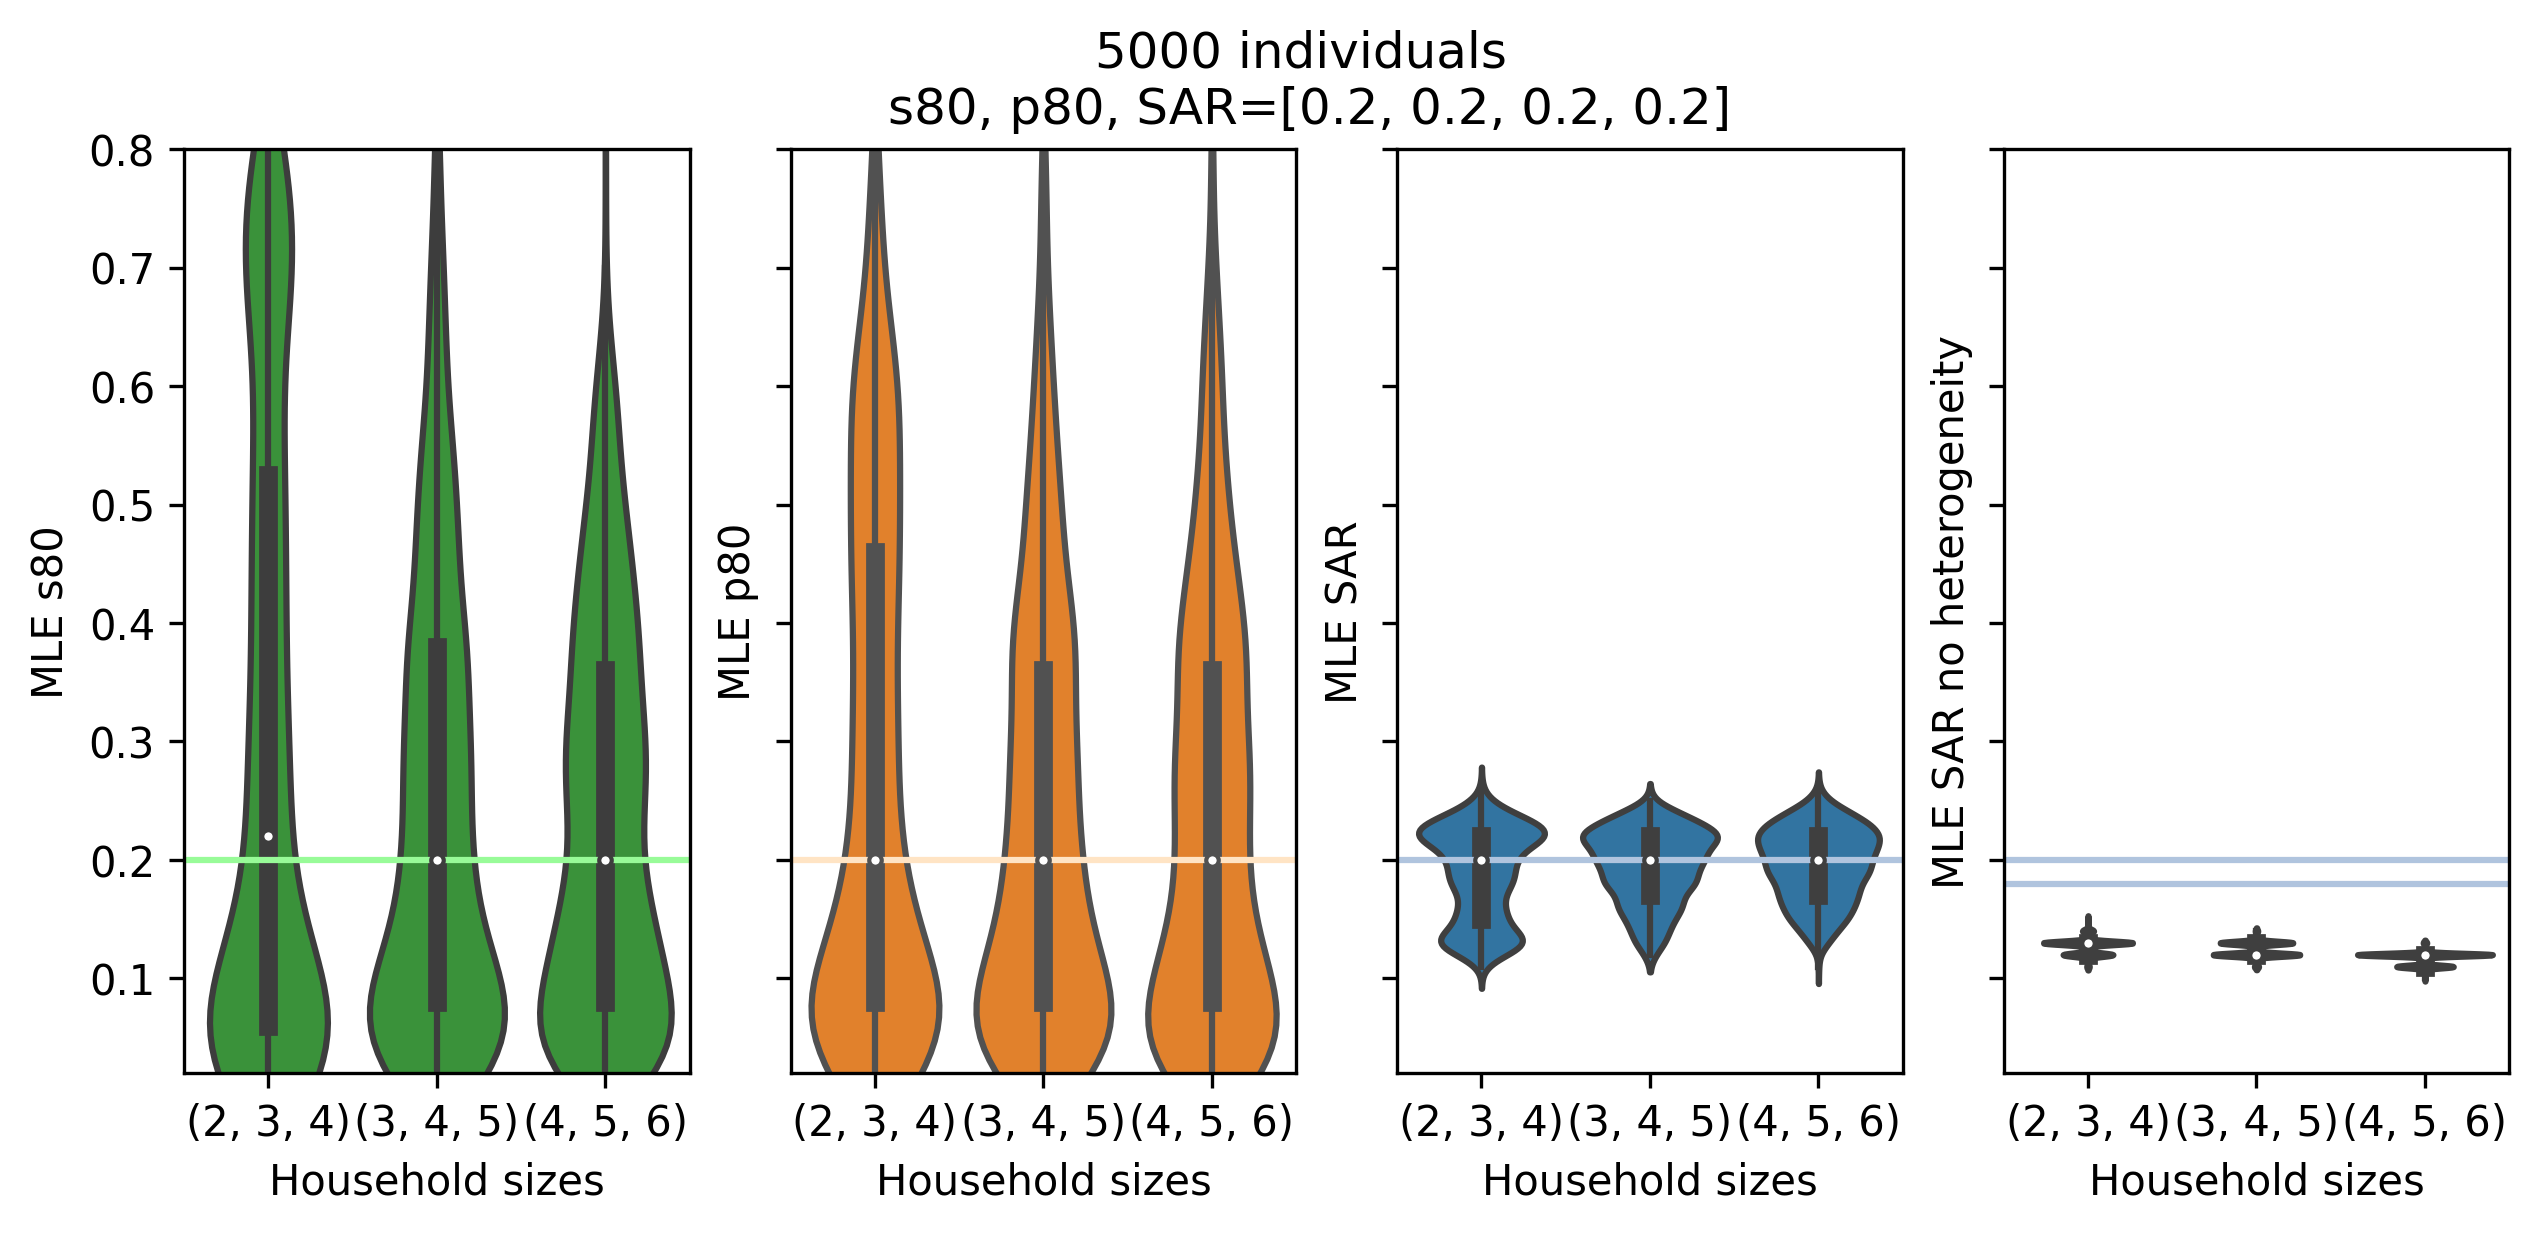

<Figure size 640x480 with 0 Axes>

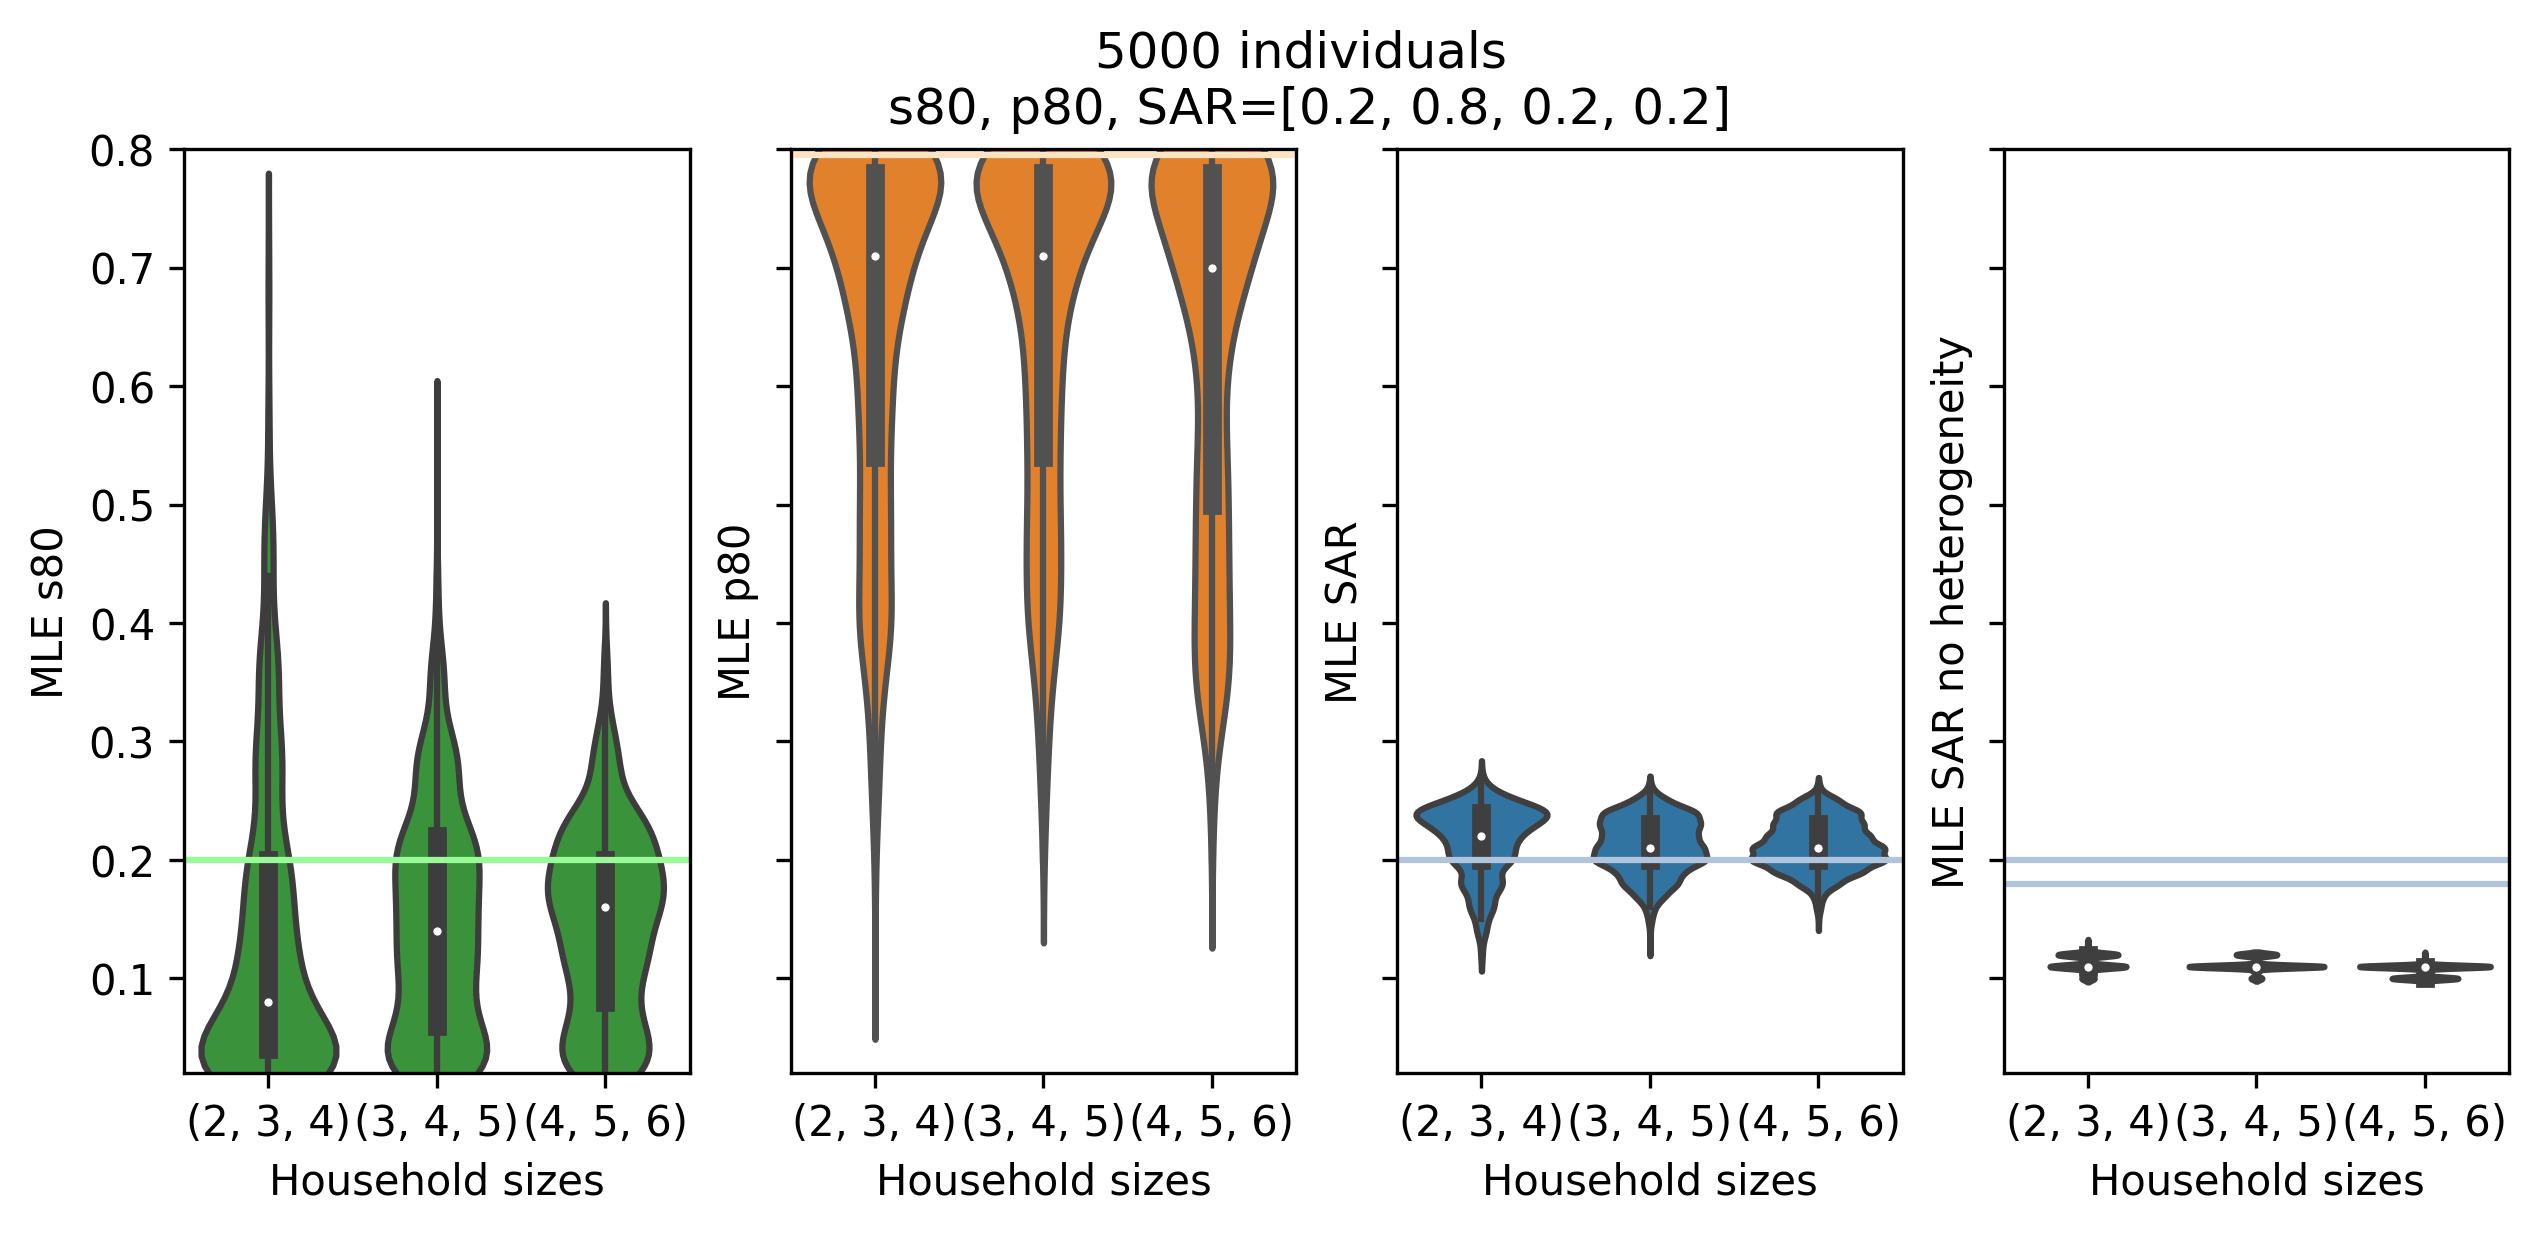

<Figure size 640x480 with 0 Axes>

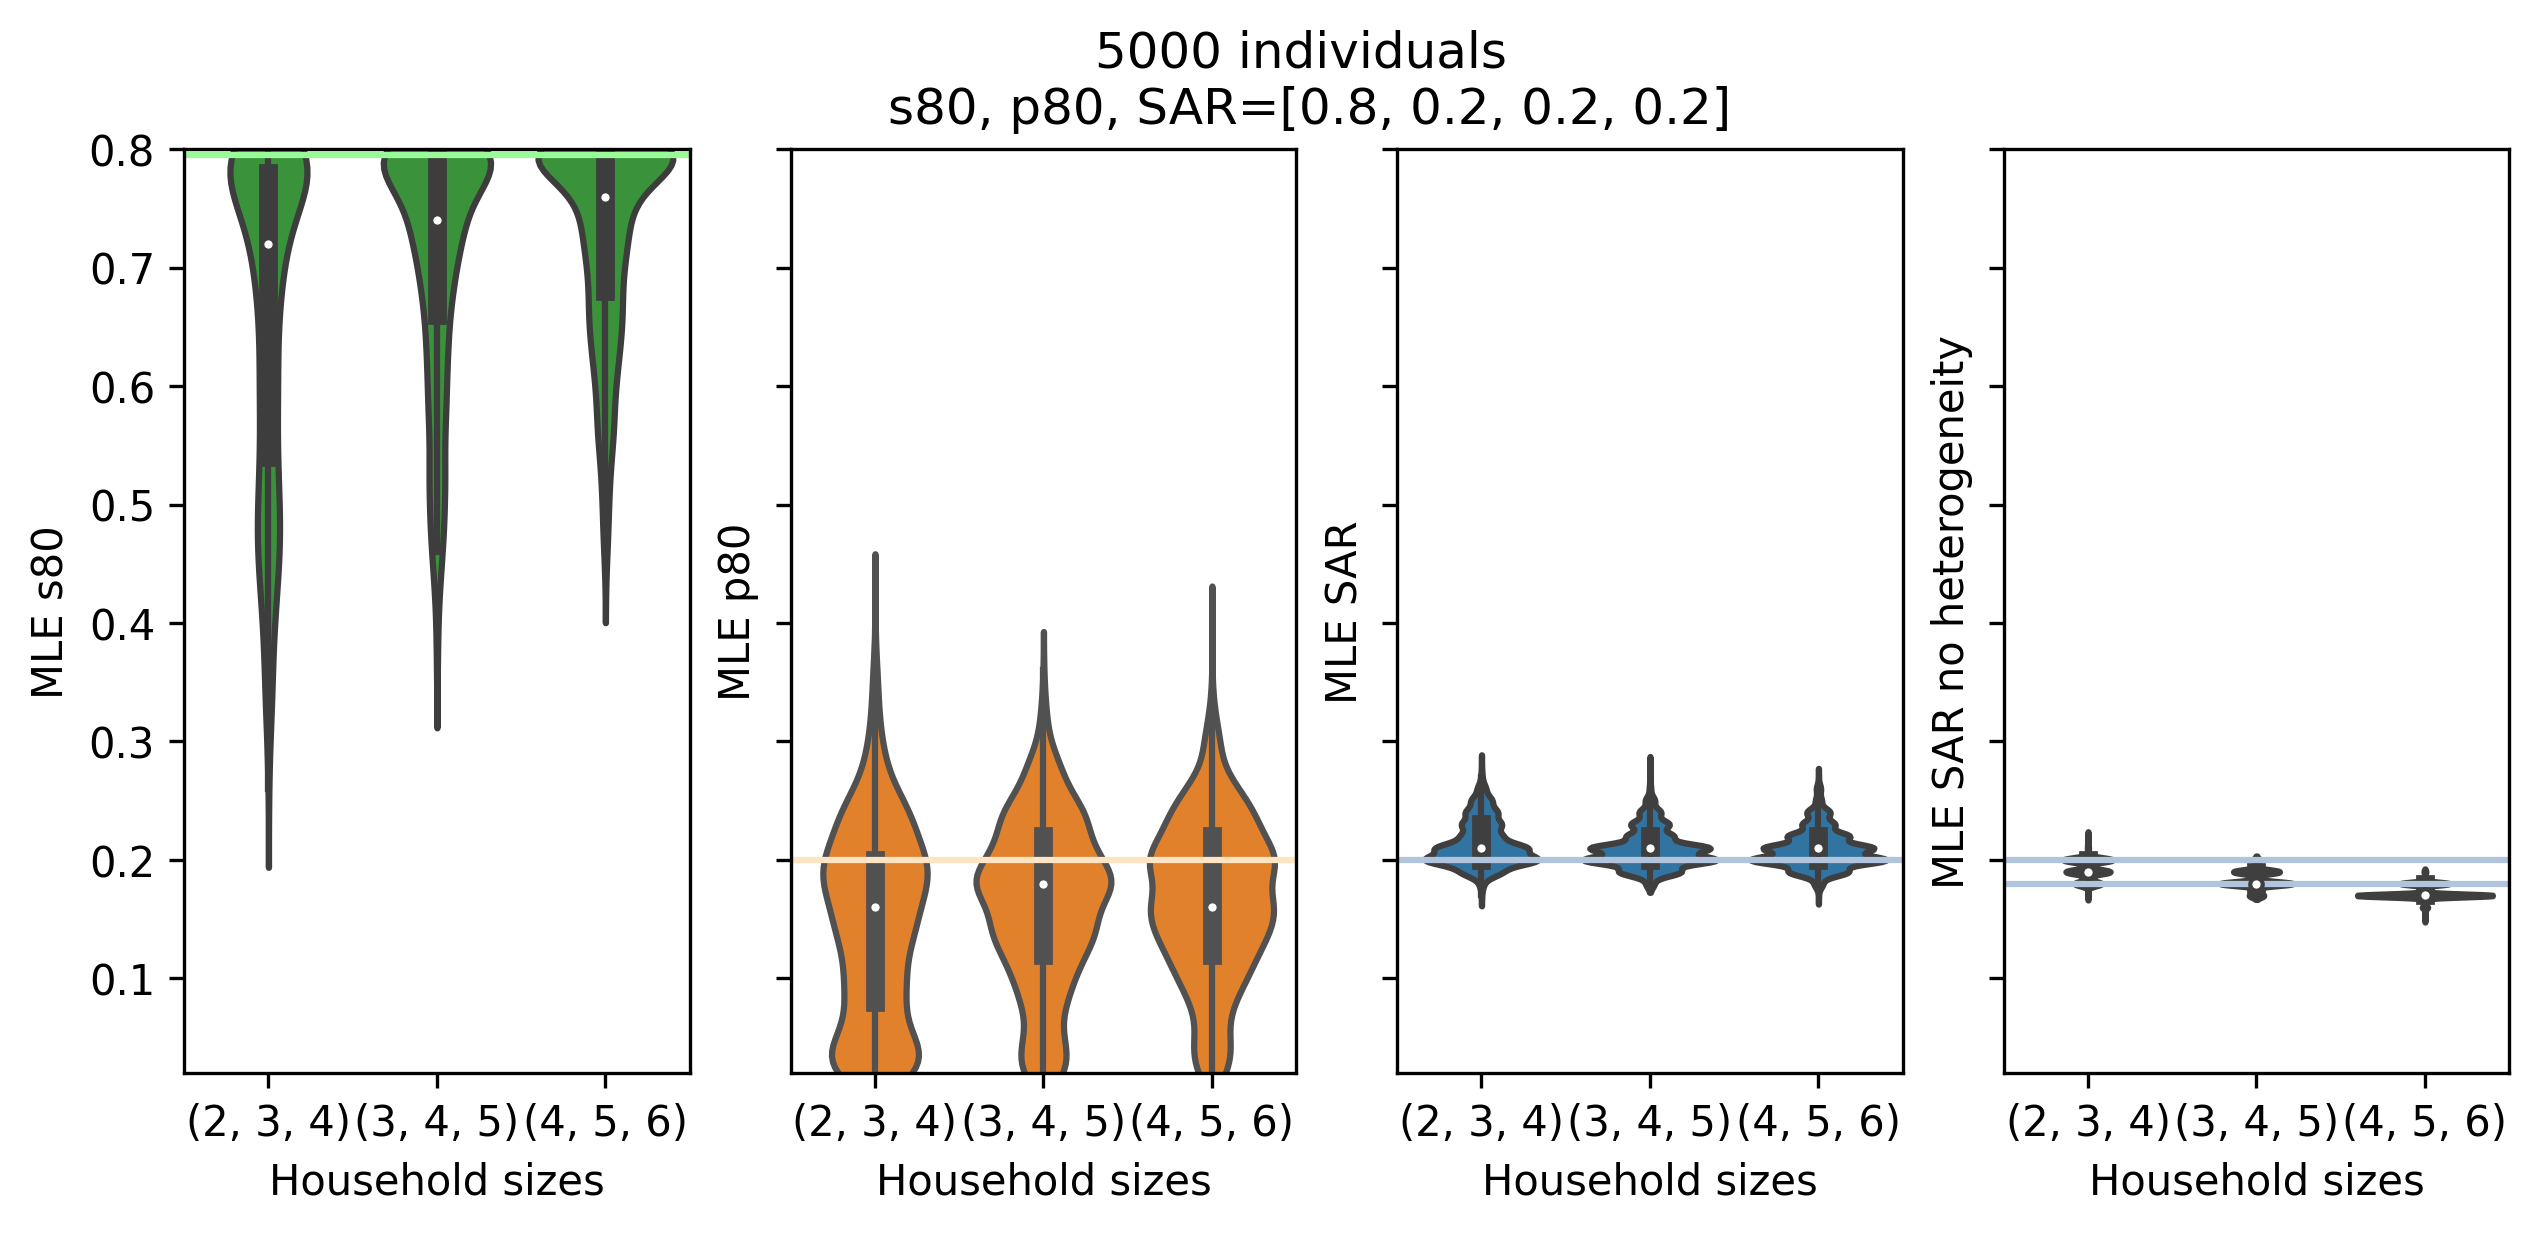

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
plt.close('all')

#hypothesis = 'SAR and susceptibility vary'
hypothesis = 'all'
fit_df = fits[hypothesis]

dpi = 300
save_figs = True

fig_sizes = {'small':(4,2.25), 'big':(10,4), 'vertical labels': (10,6)}
chosen_size = 'big'

#%matplotlib agg
min_dict = {0.6: 0.3, 0.4:0.10, 0.5: 0.15, 0.8: 0.5}
max_dict = {0.6: 0.8, 0.4:0.65, 0.5: 0.8, 0.8: 0.8}
colors = ['tab:green', 'tab:orange', 'tab:blue', 'tab:blue']
axline_colors = ['palegreen', 'bisque', 'lightsteelblue', 'lightsteelblue']
xlabels = ['MLE\ns80', 'MLE\np80', 'MLE\nSAR', 'constant traits \nMLE for SAR']

#population_mixes = [(2,3,4,), 'America_census_incl_2', (3,4,5,), 'Guatemala_incl_2', (4,5,6,)]

drop_rules = {
    'population mix': ['America_census_incl_2', 'Guatemala_incl_2'],
}

def apply_drop_rules(df, drop_rules):
    new_df = df.copy()
    for column,exclusions in drop_rules.items():
        for exclusion in exclusions:
            new_df = new_df[new_df[column] != exclusion]
    return new_df

# Use the 'drop_rules' dictionary to forget any populations we don't care about to render a cleaned up figure
new_fit_df = apply_drop_rules(fit_df, drop_rules)
new_fit_df['population mix'] = new_fit_df['population mix'].astype(str)
null_hypothesis_fit_df = apply_drop_rules(fits['null hypothesis'], drop_rules)

# add the 'null hypothesis' SAR estimates into the dataframe so they'll be an accessible column in plotting
null_SARs = null_hypothesis_fit_df['MLE_SAR']
null_SARs.name = 'MLE_SAR no heterogeneity'
new_fit_df = pd.concat([new_fit_df, null_SARs], axis=1)

grouping=['written sample size', 'parameters']
for key,group in new_fit_df.groupby(grouping):
    sample_size, parameters = key
    # The true SAR is the same regardless of null hypothesis vs standard hypothesis
    # but the `key` in the index isn't long enough because it doesn't know that we care about the null hypothesis
    # so we add the true SAR as the line for "actual value" for the null hypothesis subplot
    parameters = list(parameters) + [parameters[-1]]
    plt.figure()
    fig, axes = plt.subplots(1,len(results.metadata.parameters)+1, dpi=dpi, sharey=True, figsize=fig_sizes[chosen_size])
    #for ax in axes:
    #    ax.set_xticklabels(ax.get_xticks(), rotation = 90)
    null_fit_group = null_hypothesis_fit_df.groupby(grouping).get_group(key)
    relevant_parameters = list(results.metadata.parameters) + ['SAR no heterogeneity']
    for param_index,parameter in enumerate(relevant_parameters):
        seaborn_parameter_name = parameter
        plt.suptitle(f"{sample_size} individuals \ns80, p80, SAR={parameters}")
        sns.violinplot(x='population mix', y=f'MLE_{seaborn_parameter_name}', data=group, ax=axes[param_index], orient="v", color=colors[param_index])
        if parameters[param_index] == 0.8:
            axes[param_index].axhline(0.795, color=axline_colors[param_index])
        else:
            axes[param_index].axhline(parameters[param_index], color=axline_colors[param_index])
        mi, ma = 0.02, 0.8
        axes[param_index].set_ylim(mi, ma)

    for ax in axes:
        ax.set_ylabel(ax.get_ylabel().replace('_', ' '))
        ax.set_xlabel('Household sizes')
    
    axes[param_index].axhline(0.18, color=axline_colors[param_index])

    if save_figs:
        plt.savefig(os.path.join('../figures', f'{key}' + '.pdf'))

The cell below will plot violins for all the parameters over a group of sample sizes.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
plt.close('all')

#hypothesis = 'SAR and susceptibility vary'
hypothesis = 'all'
fit_df = fits[hypothesis]

dpi = 400
save_figs = True

fig_sizes = {'small':(4,2.25), 'big':(10,4)}
chosen_size = 'big'

#%matplotlib agg
min_dict = {0.6: 0.3, 0.4:0.10, 0.5: 0.15, 0.8: 0.5}
max_dict = {0.6: 0.8, 0.4:0.65, 0.5: 0.8, 0.8: 0.8}
colors = ['tab:green', 'tab:orange', 'tab:blue', 'tab:blue']
axline_colors = ['palegreen', 'bisque', 'lightsteelblue', 'lightsteelblue']
xlabels = ['MLE\ns80', 'MLE\np80', 'MLE\nSAR', 'constant traits \nMLE for SAR']

chosen_pop = 'America_census_incl_2'

def select_pop(df, chosen_pop):
    new_df = df.copy()
    new_df = new_df[new_df['population mix'] == chosen_pop]
    return new_df

# Choose only one population for plotting
new_fit_df = select_pop(fit_df, chosen_pop)
print(new_fit_df)
new_fit_df['population mix'] = new_fit_df['population mix'].astype(str)

# add the 'null hypothesis' SAR estimates into the dataframe so they'll be an accessible column in plotting
# but first select the population in the null hypothesis frequencies as well
null_hypothesis_fit_df = select_pop(fits['null hypothesis'], chosen_pop)
null_SARs = null_hypothesis_fit_df['MLE_SAR']
null_SARs.name = 'MLE_SAR no heterogeneity'
print(null_SARs)
new_fit_df = pd.concat([new_fit_df, null_SARs], axis=1)

grouping=['parameters']
if save_figs:
    import pyarrow as pa
    import pyarrow.parquet as pq
    new_fit_pq = pa.Table.from_pandas(new_fit_df)
    pq.write_table(new_fit_pq, os.path.join('../figures/violin_df.parquet'))
    pq.write_table(new_fit_pq, os.path.join('../figures/violin_df_null_hypothesis.parquet'))
    
for key,group in new_fit_df.groupby(grouping):
    print(group)
    parameters = key
    # The true SAR is the same regardless of null hypothesis vs standard hypothesis
    # but the `key` in the index isn't long enough because it doesn't know that we care about the null hypothesis
    # so we add the true SAR as the line for "actual value" for the null hypothesis subplot
    parameters = list(parameters) + [parameters[-1]]
    plt.figure()
    fig, axes = plt.subplots(1,len(results.metadata.parameters)+1, dpi=dpi, sharey=True, figsize=fig_sizes[chosen_size])
    null_fit_group = null_hypothesis_fit_df.groupby(grouping).get_group(key)
    relevant_parameters = list(results.metadata.parameters) + ['SAR no heterogeneity']
    for param_index,parameter in enumerate(relevant_parameters):
        seaborn_parameter_name = parameter
        plt.suptitle(f"\ns80, p80, SAR={parameters}")
        #sns.violinplot(x='written sample size', y=f'MLE_{seaborn_parameter_name}', data=group, ax=axes[param_index], orient="v", color=colors[param_index], cut=0.55)
        sns.boxplot(x='written sample size', y=f'MLE_{seaborn_parameter_name}', data=group, ax=axes[param_index], orient="v", color=colors[param_index])
        if parameters[param_index] == 0.8:
            axes[param_index].axhline(0.795, color=axline_colors[param_index])
        else:
            axes[param_index].axhline(parameters[param_index], color=axline_colors[param_index])
        mi, ma = 0.0, 0.8
        axes[param_index].set_ylim(mi, ma)
    if save_figs:
        plt.savefig(os.path.join('../figures', f'{key}' + '.pdf'))

In [ ]:
relevant_data = fit_df[(fit_df['population mix'] == (4,5,6,7,8)) & (fit_df['parameters'] == (0.4, 0.8, 0.25))]

import matplotlib.pyplot as plt
import seaborn as sns
sns.catplot(x='sample size', y='MLE_p80', kind='swarm', data=relevant_data, s=3)
plt.ylim((0.1, 0.8))

In [ ]:
null_fits = null_fit_df['MLE_SAR'].copy()
null_fits.name = 'No traits \n MLE for SAR'
version_2_df = pd.concat([fit_df, null_fits], axis=1)

params = ['population mix', 'sample size', 'parameters']
for k,g in version_2_df.groupby(params):
    data = g.drop(params, axis=1)
    plt.figure(dpi=800)
    fig = sns.violinplot(data=data)
    fig.set_ylim(0.1, 0.8)
    plt.savefig(os.path.join('../figures', 'v2' + f'{k}' + '.jpg'))
    break

In [ ]:
means = fit_df.groupby(['population mix', 'sample size', 'parameters']).mean()
stds = fit_df.groupby(['population mix', 'sample size', 'parameters']).std()
stds.columns = ['STD_' + s for s in stds.columns]

statistics = pd.concat([means, stds], axis=1)
with open('../figures/stats.csv', 'w') as f:
    statistics.to_csv(f)

In [ ]:
stds.sort_values(by='STD_MLE_s80')
with open('../figures/stds.csv', 'w') as f:
    stds.to_csv(f)

with open('../figures/means.csv', 'w') as f:
    means.to_csv(f)

# Power calculation

The cells below are used to calculate the power of an intervention that changes the $\text{SAR}$.

In [ ]:
import likelihood

def SAR_pvalue_for_trial(baseline_logl, comparison_logl, for_increase=False):
    baseline_posterior = np.exp(baseline_logl.sort_values(ascending=False)-baseline_logl.max())
    baseline_posterior = baseline_posterior/baseline_posterior.sum()
    # we groupby 'SAR' and sum so that we can capture all the probability at that SAR — regardless of other parameter values
    baseline_probability_over_sars = baseline_posterior.groupby('SAR').sum()

    comparison_posterior = np.exp(comparison_logl.sort_values(ascending=False)-comparison_logl.max())
    #print(baseline_logl.idxmax(), comparison_logl.idxmax())
    #if baseline_logl.idxmax()[3] == 0.01:
    #    import pdb; pdb.set_trace()
    #import pdb; pdb.set_trace()
    baseline_SAR_confidence_interval = likelihood.confidence_interval_from_confidence_mask(likelihood.confidence_mask_from_logl(baseline_logl, percentiles=(0.9,)), key='SAR')
    comparison_SAR_confidence_interval = likelihood.confidence_interval_from_confidence_mask(likelihood.confidence_mask_from_logl(comparison_logl, percentiles=(0.9,)), key='SAR')
    comparison_posterior = comparison_posterior/comparison_posterior.sum()
    probability_over_sars = comparison_posterior.groupby('SAR').sum()

    # use the probability surface to generate imagined MLEs
    sample1 = np.random.choice(baseline_probability_over_sars.index, 10000, p=baseline_probability_over_sars)
    sample2 = np.random.choice(probability_over_sars.index, 10000, p=probability_over_sars)

    # what fraction of the time does the first group have a increased/decreased SAR compared to the second group
    if for_increase:
        pvalue = np.count_nonzero((sample2-sample1) > 0)/len(sample1)
    else:
        pvalue = np.count_nonzero((sample2-sample1) < 0)/len(sample1)

    return pvalue, baseline_SAR_confidence_interval, comparison_SAR_confidence_interval

interval_notes = defaultdict(list)

def calculate_power_over_SAR_range(population, trials, basline_parameters, sar_range, hypotheses, for_increase=False):
    pvalue_sets = []
    for hypothesis_name in hypotheses.keys():
        frequencies = frequencies_by_hypothesis[hypothesis_name]
        for sar in sar_range:
            # replace baseline sar with target sar
            parameters = list(basline_parameters)
            parameters[results.metadata.parameters.index('SAR')] = float(f'{sar:0.3f}')
            parameters = tuple(parameters)
            #print(parameters)
   
            # get imagined infections from the simulated data at the baseline parameters to establish the probability surface for the MLE w.r.t. the baseline
            samples = results.resample(basline_parameters, population, trials=trials)
            baseline_logl = likelihood.logl_from_frequencies_and_counts(frequencies, samples['count'], results.metadata.parameters)

            # get imagined infections from the simulated data at the comparison parameters to establish the probability surface for the MLE w.r.t. the comparison point
            samples = results.resample(parameters, population, trials=trials)
            logl = likelihood.logl_from_frequencies_and_counts(frequencies, samples['count'], results.metadata.parameters)

            comparison_logl_grouped = logl.groupby('trial')
            single_trial_pvalues = []
            for key, baseline_logl_trial_group in baseline_logl.groupby('trial'):
                comparison_logl_trial_group = comparison_logl_grouped.get_group(key)
                pvalue, baseline_SAR_confidence_interval, comparison_SAR_confidence_interval = SAR_pvalue_for_trial(baseline_logl_trial_group, comparison_logl_trial_group, for_increase=for_increase)
                single_trial_pvalues.append(pvalue)
            #index = pd.MultiIndex.from_product([sar, hypothesis_name, list(range(trials))], names=['SAR', 'hypothesis', 'trial'])
            #pvalue_sets.append(pd.Series(data=single_trial_pvalues, index=index))
            pvalue_sets.append(pd.DataFrame({'pvalue':single_trial_pvalues, 'SAR':sar, 'hypothesis':hypothesis_name, 'trial':list(range(trials))}))
    df_piece = pd.concat(pvalue_sets)
    return df_piece

In [ ]:
sar_range = np.linspace(0.10, 0.15, 2)
trials = 1000
power_pvalue = 0.9

# no, medium, and high heterogeneity as defined in the paper
baseline_parameter_sets = [
    (0.8, 0.8, 0.25),
    (0.5, 0.5, 0.25),
    (0.2, 0.2, 0.25),
]

populations = [
    #{8:25},
    #{4:50},
    #{2:100},
    #{8:125},
    #{2:500},
    #{2:33, 4:17, 8:8},
    #{3:83, 4:63, 5:50, 6:42},
    #{4:83, 6:56, 8:42}
    #{4:250},
    population_mix_to_population(named_populations['America_census_incl_2'], 200),
    population_mix_to_population(named_populations['America_census_incl_2'], 1000)
    #population_mix_to_population(named_populations['Guatemala_incl_2'], 200),
    #population_mix_to_population(named_populations['Guatemala_incl_2'], 1000)
]

hypotheses = {
    'all': ['s80', 'p80', 'SAR'],
}
frequencies_by_hypothesis = {k: restrict_parameters(results, included_parameters) for k,included_parameters in hypotheses.items()}

pvalue_dfs = []
from collections import defaultdict
power_dfs = defaultdict(list)

pvalue_df_pieces = []
for baseline_parameters in baseline_parameter_sets:
    for population in populations:
        print(population)
        pvalue_df_piece = calculate_power_over_SAR_range(population, trials, baseline_parameters, sar_range, hypotheses)
        pvalue_df_piece['parameters'] = str(baseline_parameters)
        pvalue_df_piece['population'] = str(population)
        #print(pvalue_df_piece)
        pvalue_df_pieces.append(pvalue_df_piece)
        #pvalue_df = pd.DataFrame(pvalues_for_decrease, index=[float(f'{sar:0.3f}') for sar in sar_range]).transpose()
        #pvalue_dfs.append(pvalue_df)
        #power = ((pvalue_df > power_pvalue).sum()/trials)
        #power.name = str(population)
        #power_dfs[baseline_parameters].append(power)
    #import pdb; pdb.set_trace()
pvalue_df = pd.concat(pvalue_df_pieces)
pvalue_df = pvalue_df.set_index(['population', 'parameters', 'hypothesis', 'SAR', 'trial']).squeeze().unstack([0,1,2,3])
pvalue_df = (pvalue_df > 0.9).sum()/trials
pvalue_df.name = 'power'

Do a little quick rearrangement to print a pretty table.

In [ ]:
pvalue_df.unstack([1,2]).round(2)

Save that table if desired to an excel file.

In [ ]:
pvalue_df.unstack([1,2]).round(2).to_excel('../figures/powers/powers_1000_trials_SAR_25_America_fixed_0s_fixed_pop_part2.xlsx')